In [1]:
import numpy as np
import tensorflow as tf
import os
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import tensorflow as tf
print(tf.__version__)


AttributeError: module 'tensorflow' has no attribute '__version__'

In [2]:
!dir

 Volume in drive D is SecD
 Volume Serial Number is 82D5-BF62

 Directory of D:\deep_cel_shading

17/02/2023  11:40    <DIR>          .
17/02/2023  09:36             3,918 .gitignore
17/02/2023  11:18    <DIR>          .ipynb_checkpoints
17/02/2023  09:38           734,966 batch_normalization_1.png
17/02/2023  10:13           777,434 batch_normalization_10_313897.15625.png
17/02/2023  10:22           773,859 batch_normalization_11_342767.5.png
17/02/2023  10:32           775,904 batch_normalization_12_296284.8125.png
17/02/2023  10:42           777,541 batch_normalization_13_145661.0.png
17/02/2023  10:51           769,389 batch_normalization_14_387393.53125.png
17/02/2023  11:01           777,450 batch_normalization_15_287642.6875.png
17/02/2023  11:10           771,766 batch_normalization_16_303684.65625.png
17/02/2023  11:20           778,097 batch_normalization_17_93097.4609375.png
17/02/2023  11:30           725,425 batch_normalization_18_131494240.0.png
17/02/2023  11:40         

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

ModuleNotFoundError: No module named 'tensorflow.python.client'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import PIL
import sys
from PIL import Image
sys.modules['Image'] = Image 
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        return PIL.Image.fromarray(tensor)
    
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


In [4]:
content = tf.keras.preprocessing.image.load_img('raw.bmp')
style = tf.keras.preprocessing.image.load_img('ref.png')

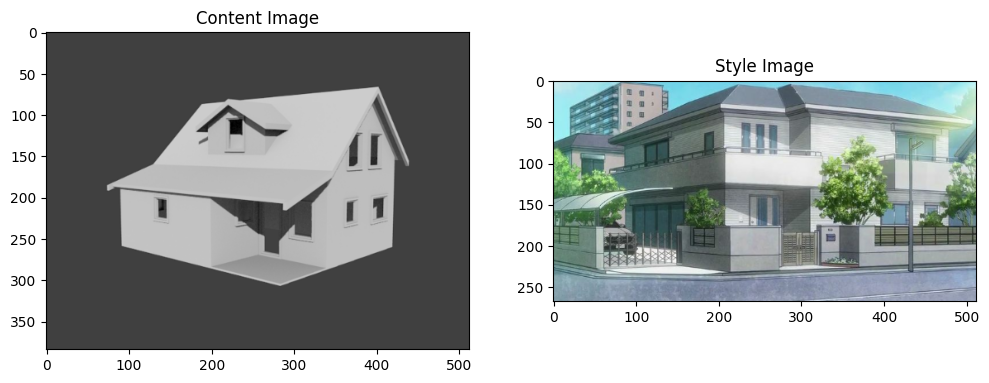

In [67]:
content_image = load_img('house_raw.png')
style_image = load_img('house_ref.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

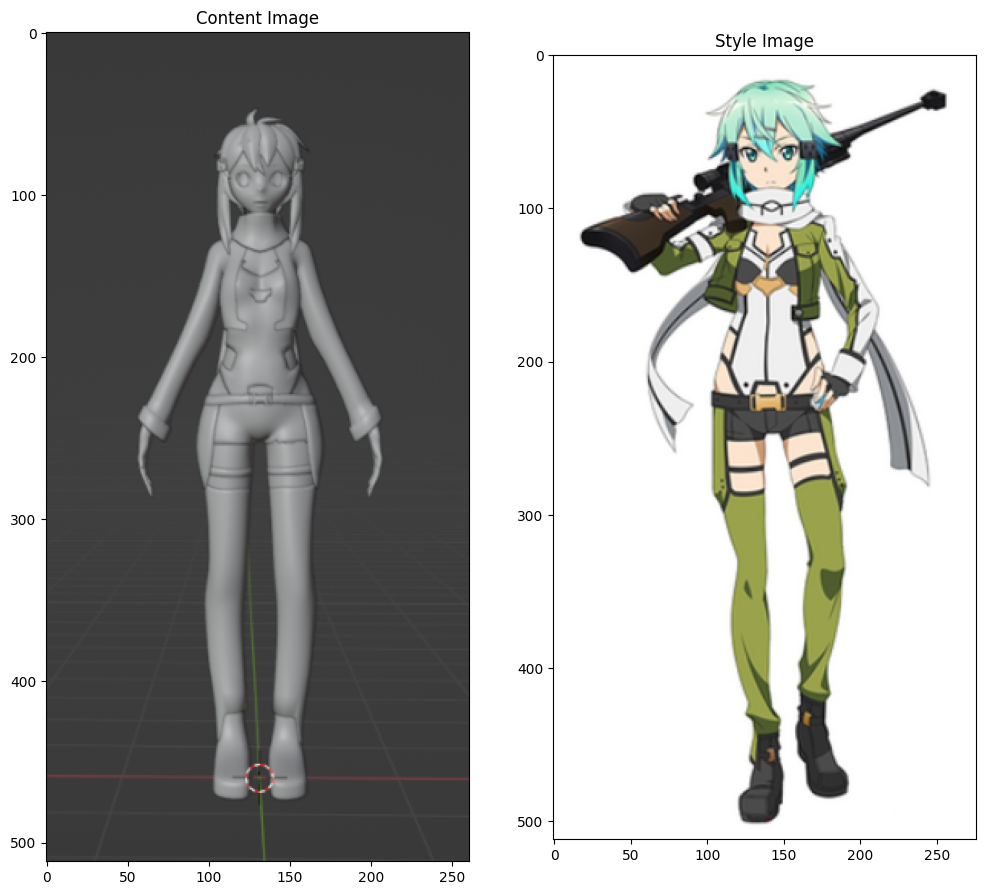

In [5]:
content_image = load_img('raw.bmp')
style_image = load_img('ref.png')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

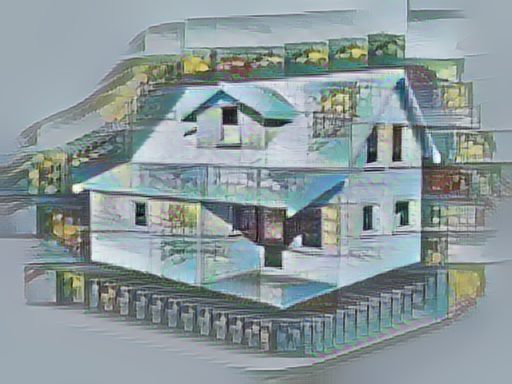

In [17]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

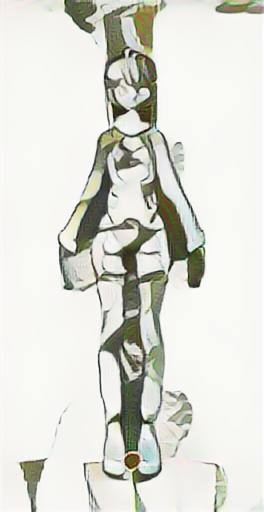

In [7]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [8]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

print(torch.cuda.is_available())

OSError: [WinError 127] The specified procedure could not be found. Error loading "D:\deep_cel_shading\venv\lib\site-packages\torch\lib\cudnn_adv_infer64_8.dll" or one of its dependencies.

In [ ]:
# def get_padding(image, size):
#     max_w = size[0] 
#     max_h = size[1]
    
#     imsize = image.size()
#     h_padding = (max_w - imsize[1]) / 2
#     v_padding = (max_h - imsize[2]) / 2
#     l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
#     t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
#     r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
#     b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    
#     padding = (int(l_pad), int(r_pad), int(t_pad), int(b_pad))
    
#     return padding

def get_square_padding(image):    
    z, w, h = image.size()
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(t_pad), int(b_pad), int(l_pad), int(r_pad))
    return padding

class PadImage(object):
    def __init__(self, fill=0, padding_mode='constant'):
        #assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        res = F.pad(img, get_square_padding(img))
        print(res.size(), get_square_padding(img), img.size())
        return res;
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)

torch.Size([3, 429, 429]) (99, 98, 0, 0) torch.Size([3, 429, 232])
torch.Size([3, 606, 606]) (148, 148, 0, 0) torch.Size([3, 606, 310])
512 torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


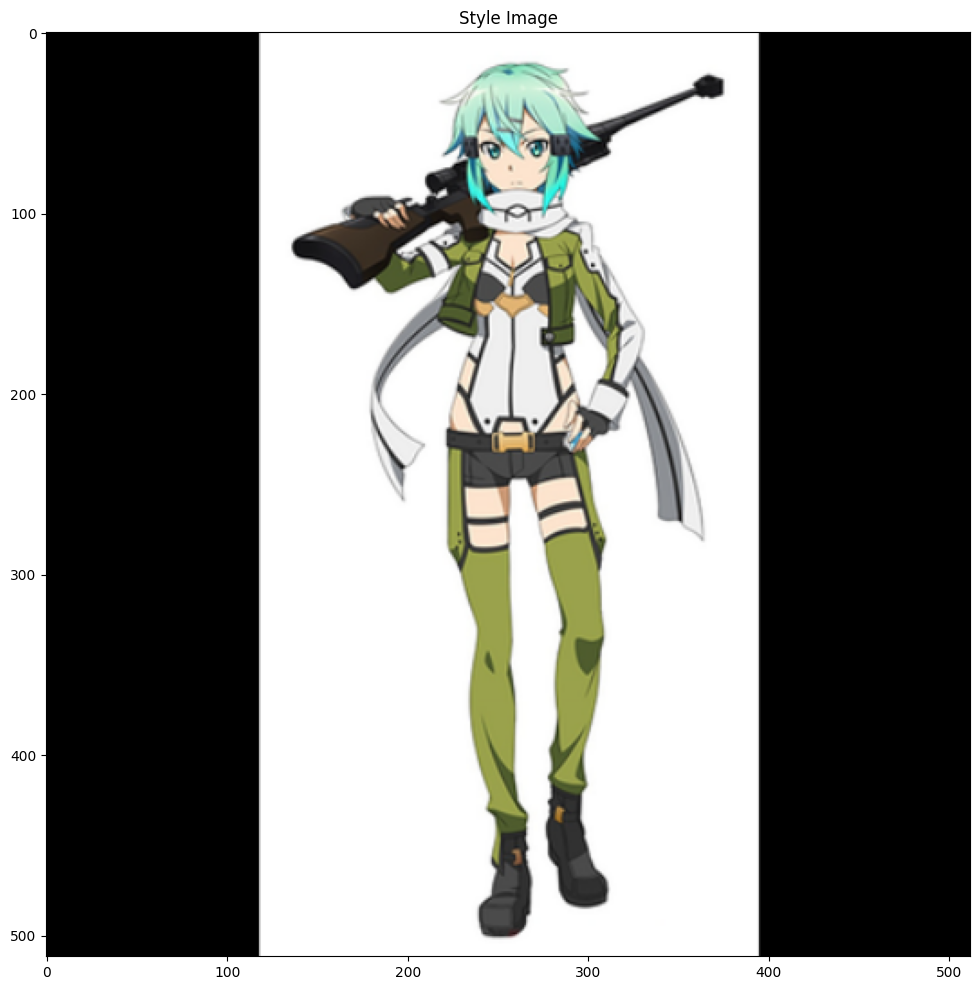

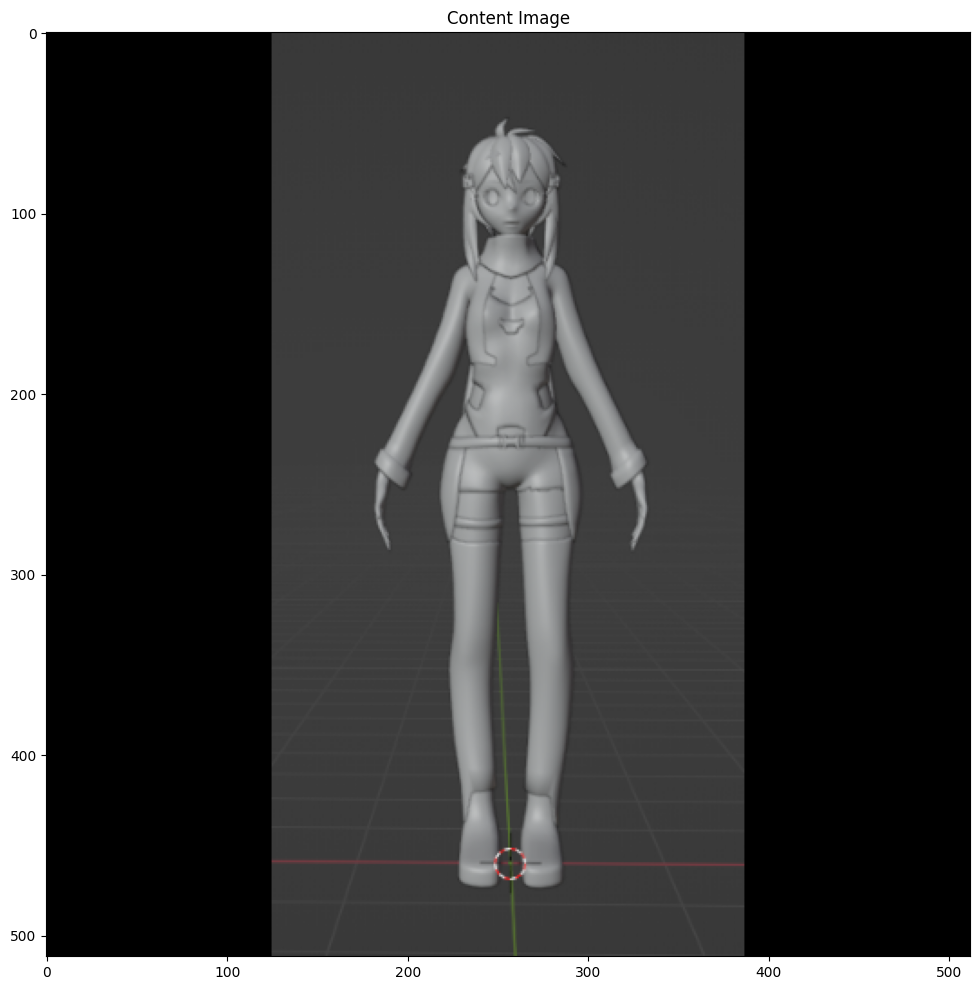

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.ToTensor(),
    PadImage(),
    transforms.Resize((imsize, imsize)),  # scale imported image
])  # transform it into a torch tensor

def pad_image(image, size):
        padded_im = F.pad(image, get_padding(image, size)) # torchvision.transforms.functional.pad
        return padded_im

def image_loader(image_name):
    image = Image.open(image_name)
    #image = pad_image(image, (imsize, imsize))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./ref.png")
content_img = image_loader("./raw.bmp")
print(imsize, style_img.size(), content_img.size())
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        print('created style loss with target size', self.target.size())

    def forward(self, input):
        print('applying loss with target size',self.target.size(), 'to input with size', input.size())
        #print(input.size())
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
class HookedBottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, orig_layer, hook):
        super(HookedBottleneck, self).__init__()
        self.layer = orig_layer
        self.hook = hook

    def forward(self, x):
        identity = x

        out = self.layer.conv1(x)
        
        out = self.hook(x)
        
        out = self.layer.bn1(out)
        out = self.layer.relu(out)

        out = self.layer.conv2(out)
        out = self.layer.bn2(out)
        out = self.layer.relu(out)

        out = self.layer.conv3(out)
        out = self.layer.bn3(out)

        if self.layer.downsample is not None:
            identity = self.layer.downsample(x)

        out += identity
        out = self.layer.relu(out)

        return out

In [111]:
import deepbooru_model

model = deepbooru_model.DeepDanbooruModel().to(device)
model.load_state_dict(torch.load("model-resnet_custom_v3.pt"))

In [6]:
model = torch.hub.load('RF5/danbooru-pretrained', 'resnet50')


Using cache found in C:\Users\yaros/.cache\torch\hub\RF5_danbooru-pretrained_master
D:\deep_cel_shading\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\deep_cel_shading\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
model = models.vgg19(pretrained=True).features.to(device).eval()


D:\deep_cel_shading\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\deep_cel_shading\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\yaros/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:17<00:00, 32.5MB/s]


In [61]:
#content_layers_default = ['conv4_2']
#style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

#content_layers_default = ['seq_5']
#style_layers_default = ['seq_2', 'seq_3', 'seq_4', 'seq_5', 'seq_6']

#content_layers_default = ['conv2_3_2_1_0000']#['conv2_6_3_1_1']
#style_layers_default = ['conv2_3_2_1_1', 'conv2_3_3_1_1', 'conv2_3_4_1_1', 'conv2_3_5_1_1', 'conv2_3_6_1_1']

content_layers_default = ['bt2_5_2']#['conv2_6_3_1_1']
style_layers_default = ['bt2_3_1', 'bt2_4_1' ]#'bt2_5_2', 'bt2_6_1'

def get_style_model_and_losses(cnn, style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, prefix="", init_model=nn.Sequential(),
                               container=None):
    # normalization module
   # normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = init_model.to(device)#(normalization)
    
    final = False
    if container is None:
        print("new model")
        container = model
        final = True
    
    i = 0
    bl = 1 
    conv_cnt = 0 # increment every time we see a conv
    
    seq_cnt = 0
        
    #for layer in next(cnn.children()).children():
    for layer in cnn.children():
        i += 1
        if isinstance(layer, nn.Conv2d):
            conv_cnt += 1
            name = 'conv{}{}_{}'.format(prefix, bl, conv_cnt)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}{}'.format(prefix, i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}'.format(i)
            bl += 1
            conv_cnt = 0
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}{}'.format(prefix, i)
        elif isinstance(layer, nn.Sequential):
            name = 'seq_{}'.format(i)
            new_layer = nn.Sequential().to(device)
            #recursion(name, new_layer, layer)
            bl += 1
            container.add_module(name, new_layer)
            print('===seq===')
            print(container)
            print(model)
            layer_o, sl, cl = get_style_model_and_losses(layer, style_img, content_img, content_layers, style_layers, 
                                                       prefix + "{}_".format(bl), model, new_layer)
            content_losses = content_losses + cl
            style_losses = style_losses + sl
            continue
            #layer = new_layer
        elif isinstance(layer, models.resnet.Bottleneck):
            name = 'bt{}{}'.format(prefix,i)
            print('orig bt', next(layer.parameters()).is_cuda)
            #recursion(name, models.resnet.Bottleneck())
            layer = layer.to(device)
            if name in content_layers:
                target = layer.conv1(model(content_img).detach())
                content_loss = ContentLoss(target)
                content_losses.append(content_loss)
                layer = HookedBottleneck(layer, content_loss).to(device)
                container.add_module(name, layer.to(device))
                continue
            elif name in style_layers:
                print('hook', name)
                target_feature = layer.conv1(model(style_img).detach())
                style_loss = StyleLoss(target_feature)
                style_losses.append(style_loss)
                layer = HookedBottleneck(layer, style_loss).to(device)
                container.add_module(name, layer.to(device))
                continue
        else:
            name = "unk({})_{}".format(layer.__class__.__name__, i)
            #raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        print(name)
        #print(container)
        container.add_module(name, layer.to(device))
        #print(container)
                
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            container.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            print(style_img.size())
            print(style_img.is_cuda, next(model.parameters()).is_cuda)
            # add style loss:
            print(model)
            target_feature = model(style_img).detach()
            print('target size', target_feature.size())
            style_loss = StyleLoss(target_feature)
            print(hex(id(target_feature)), hex(id(style_loss)))
            container.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    #if final:
    #    for i in range(len(model) - 1, -1, -1):
    #        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
    #            break

    #    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [8]:
input_img = content_img.clone()

In [29]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
    
    print('style loss count', style_losses)
    print('content loss count', content_losses)    

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    print(model)
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = style_losses[0].loss
            content_score = content_losses[0].loss

            for sl in style_losses[1:]:
                style_score += sl.loss
            for cl in content_losses[1:]:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [10]:
print(model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [62]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
output = run_style_transfer(model, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
new model
===seq===
Sequential(
  (seq_1): Sequential()
)
Sequential(
  (seq_1): Sequential()
)
conv2_1_1
bn2_2
relu2_3
pool4
===seq===
Sequential(
  (conv2_1_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_3): ReLU()
  (pool4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (seq_5): Sequential()
)
Sequential(
  (seq_1): Sequential(
    (conv2_1_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2_3): ReLU()
    (pool4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (seq_5): Sequential()
  )
)
orig bt True
hook bt2_3_1
created style loss with target size torch.Size([64, 64])
orig bt True
bt2_3_2
orig bt True
bt2_3_3
===seq===
Se

C:\Users\yaros\AppData\Local\Temp\ipykernel_23964\623587863.py:39: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = F.mse_loss(G, self.target)


RuntimeError: The size of tensor a (256) must match the size of tensor b (128) at non-singleton dimension 1

In [28]:
tm = nn.Sequential()
nl = nn.Sequential()
tm.add_module('1', nl)
nl.add_module('13', nn.Sequential())
print(tm)

Sequential(
  (1): Sequential(
    (13): Sequential()
  )
)
